## **1. Import Library**

Import Library-library yang diperlukan untuk membuat model

In [ ]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import EfficientNetB3

# Model Inference
from keras.layers import TFSMLayer
from keras import Sequential
from tensorflow.keras.preprocessing import image

## **2. Download Dataset Dari Kaggle**

Upload token yang didownload dari kaggle, kemudian download dataset animals dari kaggle

In [3]:
!pip install -q kaggle

uploaded = files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d antobenedetti/animals -p /content/sample_data

!unzip -q /content/sample_data/animals.zip -d /content/sample_data/

Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/antobenedetti/animals
License(s): GPL-2.0


## **3. Exploratory Data Analysis (EDA)**

### **3.1. Data Inspection**

Pengecekan Dimensi dan Total gambar yang ada dalam dataset. Dari dataset ini memenuhi kriteria saran nomor 2 dan 3, yaitu:
*   **Gambar-gambar pada dataset asli memiliki resolusi yang tidak seragam (Tanpa preprocessing)**
*   **Dataset yang digunakan berisi minimal 10000 gambar.**



In [4]:
folder = "/content/sample_data/animals"
sizes = {}
total_images = 0

for root, dirs, files in os.walk(folder):
    for filename in files:
        if filename.endswith((".jpg", ".png", ".jpeg")):
            path = os.path.join(root, filename)
            try:
                img = Image.open(path)
                sizes[filename] = img.size
                total_images += 1
            except:
                print(f"Gagal membuka gambar: {path}")

# Tampilkan ukuran gambar per file
for fname, size in sizes.items():
    print(f"{fname}: {size}")

# Tampilkan total jumlah gambar
print(f"\nTotal gambar di dalam folder '{folder}': {total_images}")

cat92.jpg: (512, 512)
cat46.jpg: (512, 512)
cat7.jpg: (512, 512)
cat81.jpg: (512, 512)
cat25.jpg: (512, 512)
cat29.jpg: (512, 512)
cat237.jpg: (512, 512)
cat96.jpg: (512, 512)
cat194.jpg: (512, 512)
cat80.jpg: (512, 512)
cat288.jpg: (512, 512)
cat290.jpg: (512, 512)
cat236.jpg: (512, 512)
cat74.jpg: (512, 512)
cat78.jpg: (512, 512)
cat186.jpg: (512, 512)
cat83.jpg: (512, 512)
cat242.jpg: (512, 512)
cat34.jpg: (512, 512)
cat98.jpg: (512, 512)
cat114.jpg: (512, 512)
cat124.jpg: (512, 512)
cat214.jpg: (512, 512)
cat121.jpg: (512, 512)
cat18.jpg: (512, 512)
cat108.jpg: (512, 512)
cat208.jpg: (512, 512)
cat90.jpg: (512, 512)
cat226.jpg: (512, 512)
cat128.jpg: (512, 512)
cat19.jpg: (512, 512)
cat122.jpg: (512, 512)
cat32.jpg: (512, 512)
cat181.jpg: (512, 512)
cat188.jpg: (512, 512)
cat261.jpg: (512, 512)
cat65.jpg: (512, 512)
cat230.jpg: (512, 512)
cat216.jpg: (512, 512)
cat107.jpg: (512, 512)
cat158.jpg: (512, 512)
cat199.jpg: (512, 512)
cat94.jpg: (512, 512)
cat53.jpg: (512, 512)
cat240.jp

### **3.2. Data Preparation**

Penggabungan folder train dan val menjadi 1 folder bernama dataset, tujuannya untuk memudahkan saat image preprocessing pada tahap selanjutnya.

In [5]:
train_dir = "/content/sample_data/animals/train"
valid_dir = "/content/sample_data/animals/val"
combined_dir = "/content/sample_data/animals/dataset"

os.makedirs(combined_dir, exist_ok=True)

for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

for category in os.listdir(valid_dir):
    category_dir = os.path.join(valid_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

### **3.3. Dataset Checking**

Menampilkan 5 gambar acak dari setiap kelas dalam dataset gambar yang disimpan dalam folder, dengan satu baris per kelas.

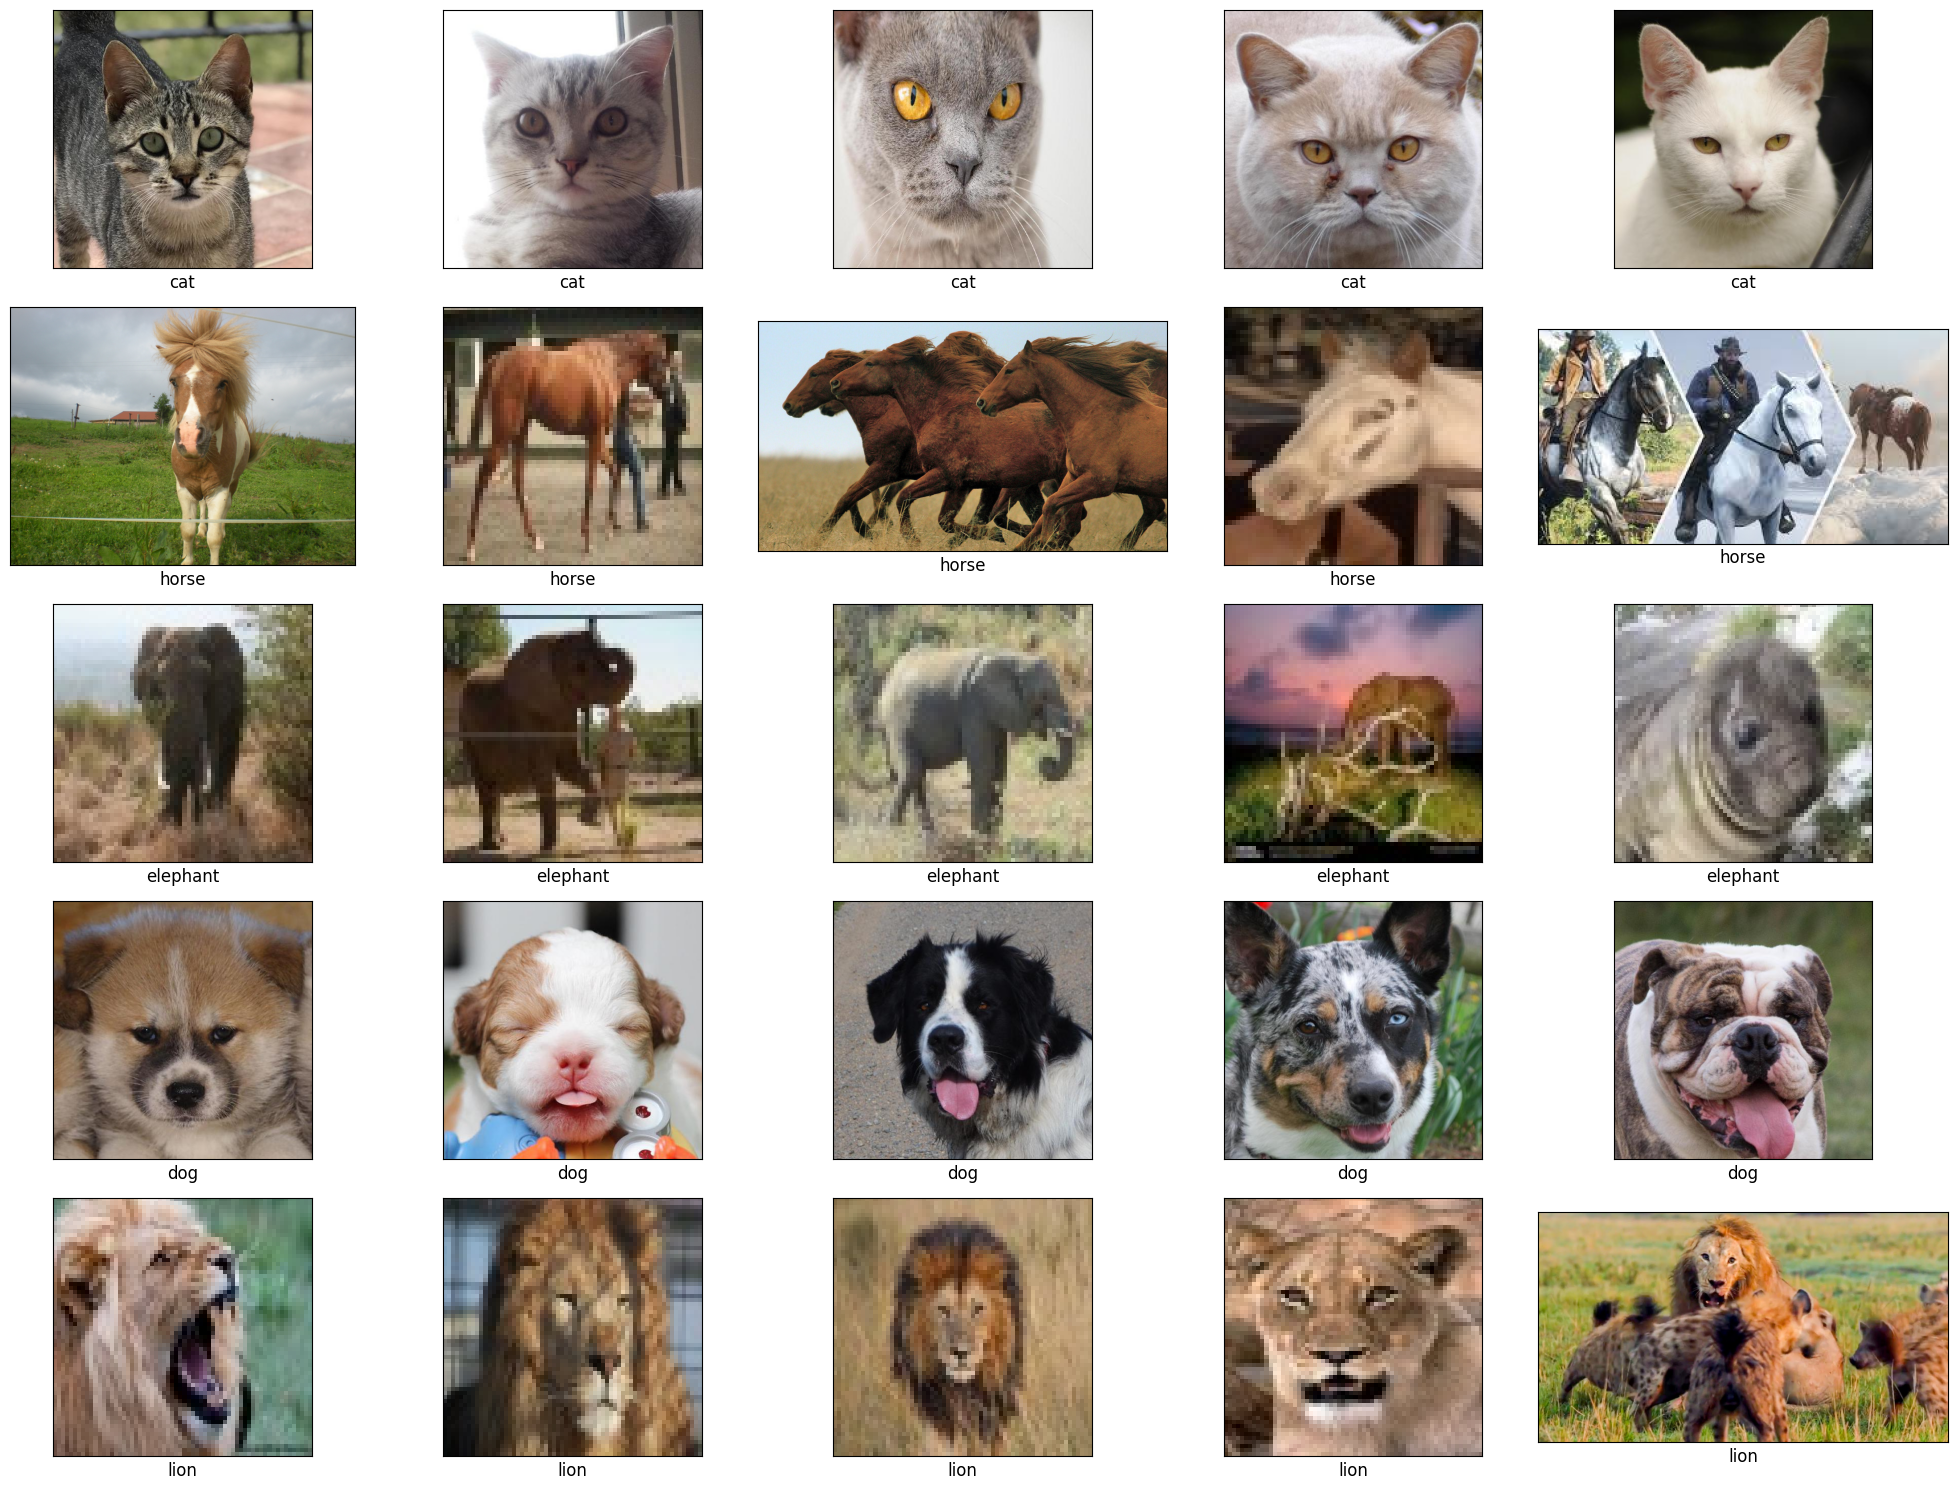

In [6]:
# Membuat kamus yang menyimpan daftar nama file gambar untuk setiap kelas dalam data
garbages_image = {}

# Tentukan path sumber train
path = "/content/sample_data/animals"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    garbages_image[i] = os.listdir(os.path.join(path_sub, i))

# Path dataset untuk menampilkan gambar
dataset_path = os.path.join(path, "dataset")

# Sesuaikan ukuran canvas: tinggi canvas disesuaikan dengan jumlah kelas (misal 3 inci per kelas)
n_classes = len(garbages_image.keys())
fig, axs = plt.subplots(n_classes, 5, figsize=(20, n_classes * 3))

# Jika hanya ada satu kelas, pastikan axs berbentuk 2D agar loop di bawah dapat berjalan
if n_classes == 1:
    axs = np.expand_dims(axs, axis=0)

# Menampilkan 5 gambar acak untuk setiap kelas
for i, class_name in enumerate(os.listdir(dataset_path)):
    images = np.random.choice(garbages_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(dataset_path, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set_xlabel(class_name, fontsize=12)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

fig.tight_layout()
plt.show()

### **3.4. Dataset Distribution**

Memvisualisasi Jumlah kelas dan jumlah image yang ada dalam dataset. Dari hasil yang ditunjukan terdapat 5 kelas animals yaitu cat, horse, elephant, dog dan lion. Dari hasil ini juga memenuhi saran nomor 5 yaitu :
*   **Memiliki 3 buah kelas atau lebih.**

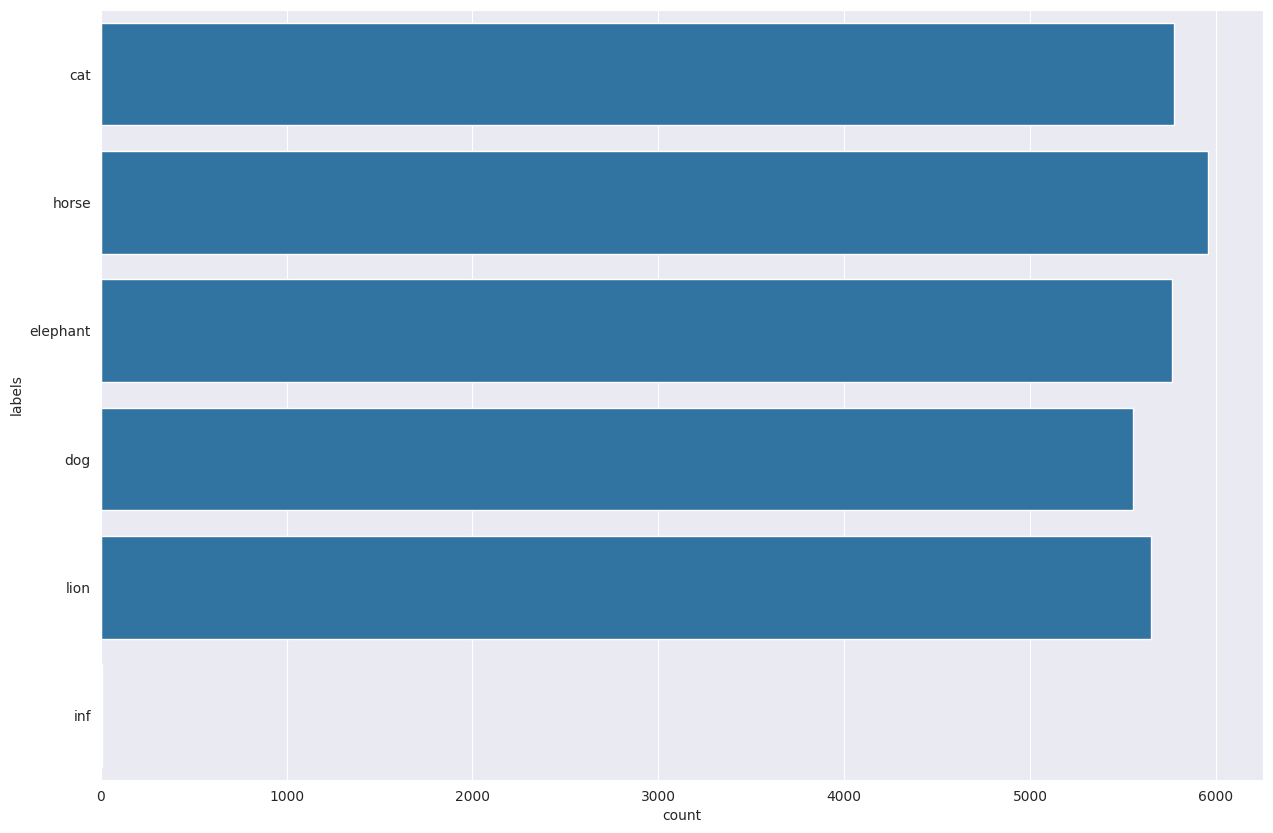

In [8]:
# Definisikan path sumber
garbages_path = "/content/sample_data/animals"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(garbages_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (15,10))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

## **4. Data Augmentation**

Melakukan augmentasi data dengan mengambil gambar secara acak dari folder dataset, lalu menerapkan transformasi acak seperti rotasi searah/berlawanan jarum jam dan shear, kemudian menyimpan gambar hasil augmentasi ke folder baru hingga mencapai 10.000 gambar.

In [9]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,30)
    return rotate(img, sudut)

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,30)
    return rotate(img, -sudut)

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

# Membuat variabel transformasi yang akan menyimpan semua proses pra-pemrosesan yang telah dilakukan sebelumnya
transformations = { 'rotate anticlockwise': anticlockwise_rotation,
                    'rotate clockwise': clockwise_rotation,
                    'shear image': sheared
                  }

images_path="/content/sample_data/animals/dataset" # Path untuk gambar asli
augmented_path="/content/sample_data/animals/dataset-augmented" # Path untuk gambar yang sudah diaugmentasi
images=[] # Penyimpanan gambar yang telah melalui pra-pemrosesan

# Baca nama gambar dari folder dan tambahkan path ke dalam array "images"
for class_folder in os.listdir(images_path):
    class_path = os.path.join(images_path, class_folder)
    if os.path.isdir(class_path):
        for im in os.listdir(class_path):
            images.append(os.path.join(class_path, im))

images_to_generate = 10000
i = 1

while i <= images_to_generate:
    image = random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image = original_image.copy()

        # Ambil label dari nama folder
        label = os.path.basename(os.path.dirname(image))
        save_dir = os.path.join(augmented_path, label)
        os.makedirs(save_dir, exist_ok=True)

        # Terapkan transformasi acak
        n = 0
        transformation_count = random.randint(1, len(transformations))  # jumlah transformasi yang akan diterapkan

        while n < transformation_count:
            key = random.choice(list(transformations))  # ambil nama transformasi acak
            transformed_image = transformations[key](transformed_image)
            n += 1

        # Simpan hasil gambar
        new_image_path = os.path.join(save_dir, f"augmented_image_{i}.jpg")
        transformed_image = img_as_ubyte(transformed_image)
        cv2.imwrite(new_image_path, transformed_image)
        i += 1

    except Exception as e:
        print(f'Could not process image {image} : {e}, skipping...')

Could not process image /content/sample_data/animals/dataset/elephant/elephant2732.png : OpenCV(4.11.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:843: error: (-215:Assertion failed) image.channels() == 1 || image.channels() == 3 || image.channels() == 4 in function 'imwrite_'
, skipping...
Could not process image /content/sample_data/animals/dataset/lion/lion2674.png : OpenCV(4.11.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:843: error: (-215:Assertion failed) image.channels() == 1 || image.channels() == 3 || image.channels() == 4 in function 'imwrite_'
, skipping...


In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))

for i in range(3):
    for j in range(3):
        img_path = random.choice(images) 
        img = io.imread(img_path)  
        label = os.path.basename(os.path.dirname(img_path)) 

        transformed = img.copy()
        for _ in range(random.randint(1, 2)):
            transformed = random.choice(list(transformations.values()))(transformed)

        axs[i, j].imshow(transformed)
        axs[i, j].axis("off")
        axs[i, j].set_title(label)

plt.tight_layout()
plt.show()

Memvisualisasi hasil dari Augmenatsi pada image-image yang ada dalam dataset pada tahap sebelumnya.

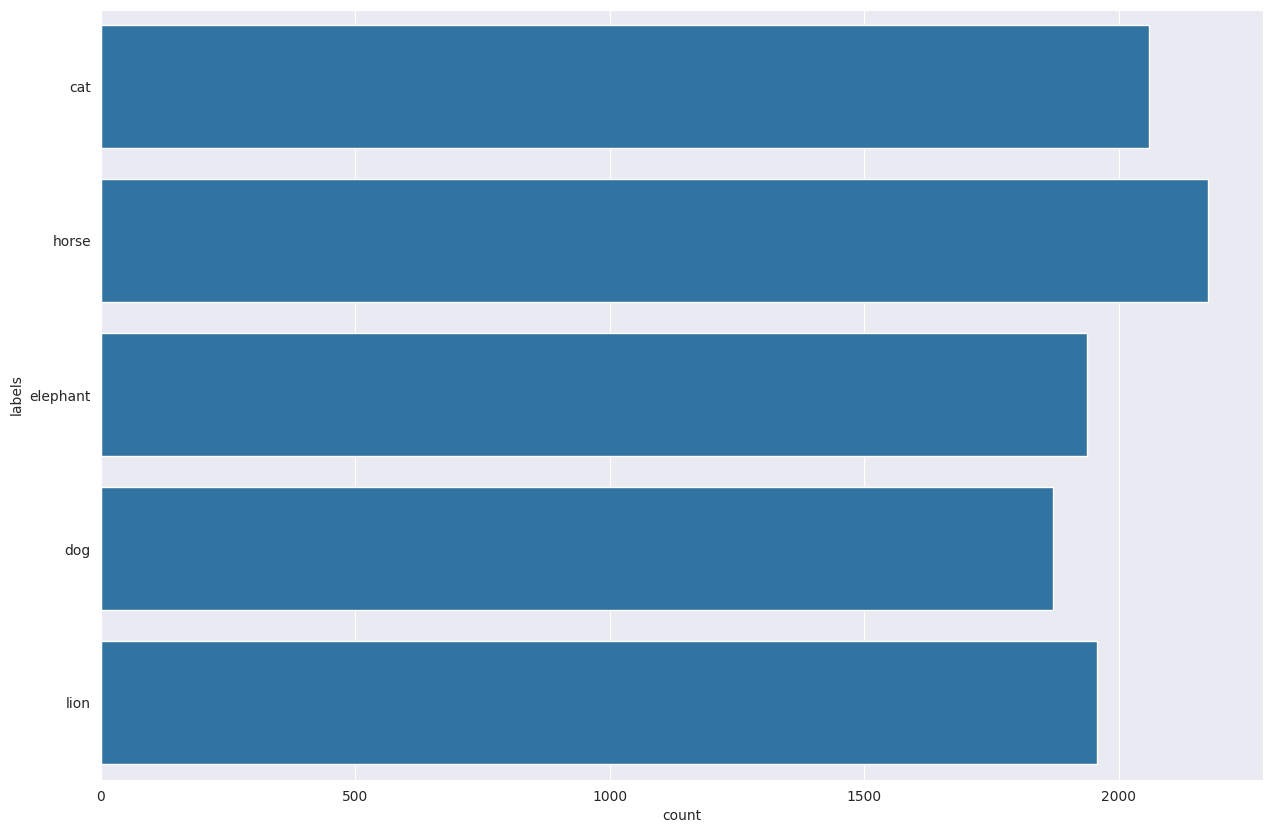

In [10]:
# Definisikan path sumber
sports_path = "/content/sample_data/animals/dataset-augmented"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(sports_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (15,10))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

## **5. Data Splitting**

Mengumpulkan path, nama file, dan label dari dataset, lalu menyimpannya dalam bentuk DataFrame.

In [11]:
# Path ke dataset awal
mypath = '/content/sample_data/animals/dataset'

# Kumpulkan path file dan label
file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(os.path.basename(path))  # Label = nama folder (kelas)
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
cat,2737
dog,2627
elephant,2732
horse,2951
lion,2678


Membagi dataset menjadi data training (70%), validasi (15%), dan testing (15%) secara proporsional berdasarkan label.

In [12]:
# Split data: train (70%), valid (15%), test (15%)
X = df['path']
y = df['labels']

# Split train dan temp (valid + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=300)

# Split valid dan test
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=300)

Membuat DataFrame untuk masing-masing data (train, validasi, test), lalu menyalin file gambar ke folder baru sesuai set dan labelnya.

In [13]:
# Satukan ke dalam masing-masing dataframe
df_train = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_valid = pd.DataFrame({'path': X_valid, 'labels': y_valid, 'set': 'valid'})
df_test = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})

# Gabungkan semua
df_all = pd.concat([df_train, df_valid, df_test], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "/content/sample_data/animals/dataset"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "/content/sample_data/submission/"

for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)


set    labels  
test   cat          410
       dog          394
       elephant     410
       horse        443
       lion         402
train  cat         1916
       dog         1839
       elephant    1912
       horse       2066
       lion        1874
valid  cat          411
       dog          394
       elephant     410
       horse        442
       lion         402
dtype: int64 


                                                    path labels    set
12562  /content/sample_data/animals/dataset/horse/hor...  horse   test
8852   /content/sample_data/animals/dataset/horse/hor...  horse  train
771    /content/sample_data/animals/dataset/dog/dog86...    dog  train
4373   /content/sample_data/animals/dataset/cat/cat16...    cat  train
12141  /content/sample_data/animals/dataset/dog/dog16...    dog   test


0it [00:00, ?it/s]

## **6. Image Data Generator**

Menampilkan jumlah gambar pada setiap kelas di folder train, validasi, dan test.

In [14]:
# Path direktori dataset
TRAIN_DIR = "/content/sample_data/submission/train/"
VALID_DIR = "/content/sample_data/submission/test/"
TEST_DIR = "/content/sample_data/submission/valid/"

# Fungsi untuk menampilkan jumlah gambar per kelas
def print_class_distribution(directory, set_name):
    print(f"\nJumlah gambar di {set_name.upper()} set:")
    for class_name in sorted(os.listdir(directory)):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            total = len(os.listdir(class_path))
            print(f"  {class_name:<30}: {total} gambar")

# Tampilkan distribusi semua kelas untuk train, valid, test
print_class_distribution(TRAIN_DIR, "train")
print_class_distribution(VALID_DIR, "valid")
print_class_distribution(TEST_DIR, "test")


Jumlah gambar di TRAIN set:
  cat                           : 1916 gambar
  dog                           : 1839 gambar
  elephant                      : 1912 gambar
  horse                         : 2066 gambar
  lion                          : 1874 gambar

Jumlah gambar di VALID set:
  cat                           : 410 gambar
  dog                           : 394 gambar
  elephant                      : 410 gambar
  horse                         : 443 gambar
  lion                          : 402 gambar

Jumlah gambar di TEST set:
  cat                           : 411 gambar
  dog                           : 394 gambar
  elephant                      : 410 gambar
  horse                         : 442 gambar
  lion                          : 402 gambar


Membuat data generator untuk train, validasi, dan test dengan augmentasi pada train dan validasi, serta penskalaan gambar untuk semua set.

In [29]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # dikurangi
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.05,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224,224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 9607 images belonging to 5 classes.
Found 2059 images belonging to 5 classes.
Found 2059 images belonging to 5 classes.


## **7. Model Building**

Membangun model klasifikasi berbasis EfficientNetB3 yang ditambahkan beberapa layer CNN dan Dense, lalu dikompilasi dengan Adam optimizer dan fungsi loss kategorikal.

In [ ]:
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

model = Sequential()
model.add(base_model)
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(120, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

plot_model(model, show_shapes=True, show_layer_names=True)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 7, 7, 1536)          │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 256)           │       3,539,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 256)                 │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 120)                 │          30,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 32)                  │           3,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,947,692 (57.02 MB)

 Trainable params: 14,860,389 (56.69 MB)

 Non-trainable params: 87,303 (341.03 KB)

## **8. Model Training**

Melatih model dengan penyesuaian bobot kelas agar seimbang, sambil menggunakan callback untuk menghentikan pelatihan dini, menurunkan learning rate saat validasi memburuk, dan menyimpan model terbaik selama proses training. Karena menggunakan callback harusnya memenuhi saran nomor 1, yaitu :

*   **Mengimplementasikan Callback**

In [34]:
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=3),
    ModelCheckpoint('submission/best_model.keras', save_best_only=True),
]


# --- TRAINING PHASE 1: train Dense only ---
history1 = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 372s 820ms/step - accuracy: 0.2862 - loss: 1.8570 - val_accuracy: 0.4541 - val_loss: 1.3556 - learning_rate: 1.0000e-05
Epoch 2/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 194s 644ms/step - accuracy: 0.5925 - loss: 1.0141 - val_accuracy: 0.8431 - val_loss: 0.4619 - learning_rate: 1.0000e-05
Epoch 3/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 178s 591ms/step - accuracy: 0.7393 - loss: 0.6744 - val_accuracy: 0.9223 - val_loss: 0.2394 - learning_rate: 1.0000e-05
Epoch 4/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 179s 595ms/step - accuracy: 0.8296 - loss: 0.4732 - val_accuracy: 0.9354 - val_loss: 0.1959 - learning_rate: 1.0000e-05
Epoch 5/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 181s 602ms/step - accuracy: 0.8713 - loss: 0.3607 - val_accuracy: 0.9330 - val_loss: 0.1882 - learning_rate: 1.0000e-05
Epoch 6/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 190s 632ms/step - accuracy: 0.8895 - loss: 0.3226 - val_accuracy: 0.9451 - val_loss: 0.1681 - learning_rate: 1.0000e-05
Epoch 7/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 

## **9. Model Evaluation**

Grafik di bawah menunjukkan bahwa akurasi model meningkat secara stabil baik pada data training maupun validasi, sementara nilai loss terus menurun tanpa tanda-tanda overfitting, yang menandakan model berhasil belajar dengan baik.

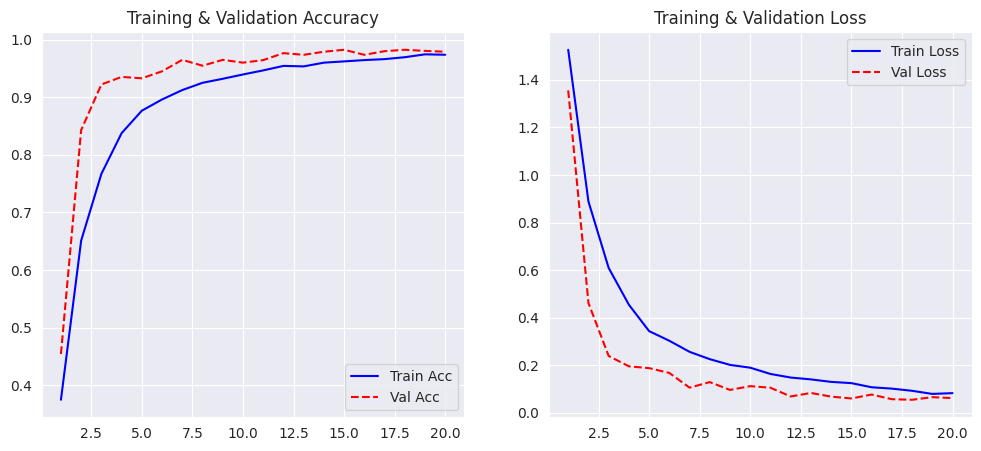

In [37]:
acc   = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss  = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(acc)+1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc,    'b-', label='Train Acc')
plt.plot(epochs, val_acc,'r--', label='Val Acc')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss,    'b-', label='Train Loss')
plt.plot(epochs, val_loss,'r--', label='Val Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()

Mengevaluasi performa model pada data training dan testing, dan hasilnya menunjukkan akurasi tinggi: 99.22% di training dan 98.40% di testing, yang berarti model bekerja sangat baik dan generalisasinya kuat. Karena hasil akurasinya 99% dan 98%, seharusnya memenuhi saran dari nomor 4 yaitu:

*   **Akurasi pada training set dan testing set minimal 95%.**

In [38]:
train_loss, train_acc = model.evaluate(train_generator, verbose=1)
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"\nTrain accuracy: {train_acc*100:.2f}%")
print(f"\nTest accuracy: {test_acc*100:.2f}%")

301/301 ━━━━━━━━━━━━━━━━━━━━ 147s 490ms/step - accuracy: 0.9921 - loss: 0.0249


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2059/2059 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - accuracy: 0.9946 - loss: 0.0157

Train accuracy: 99.22%

Test accuracy: 98.40%


Model berhasil mengklasifikasikan gambar dengan sangat akurat, dilihat dari akurasi 98% dan nilai precision, recall, serta f1-score yang tinggi di semua kelas, dengan sedikit kesalahan klasifikasi yang terlihat pada confusion matrix, seperti gambar “lion” yang kadang diprediksi sebagai “elephant” atau “horse”.

2059/2059 ━━━━━━━━━━━━━━━━━━━━ 33s 12ms/step
              precision    recall  f1-score   support

         cat       1.00      1.00      1.00       411
         dog       1.00      1.00      1.00       394
    elephant       0.97      0.98      0.98       410
       horse       0.97      0.98      0.98       442
        lion       0.98      0.96      0.97       402

    accuracy                           0.98      2059
   macro avg       0.98      0.98      0.98      2059
weighted avg       0.98      0.98      0.98      2059



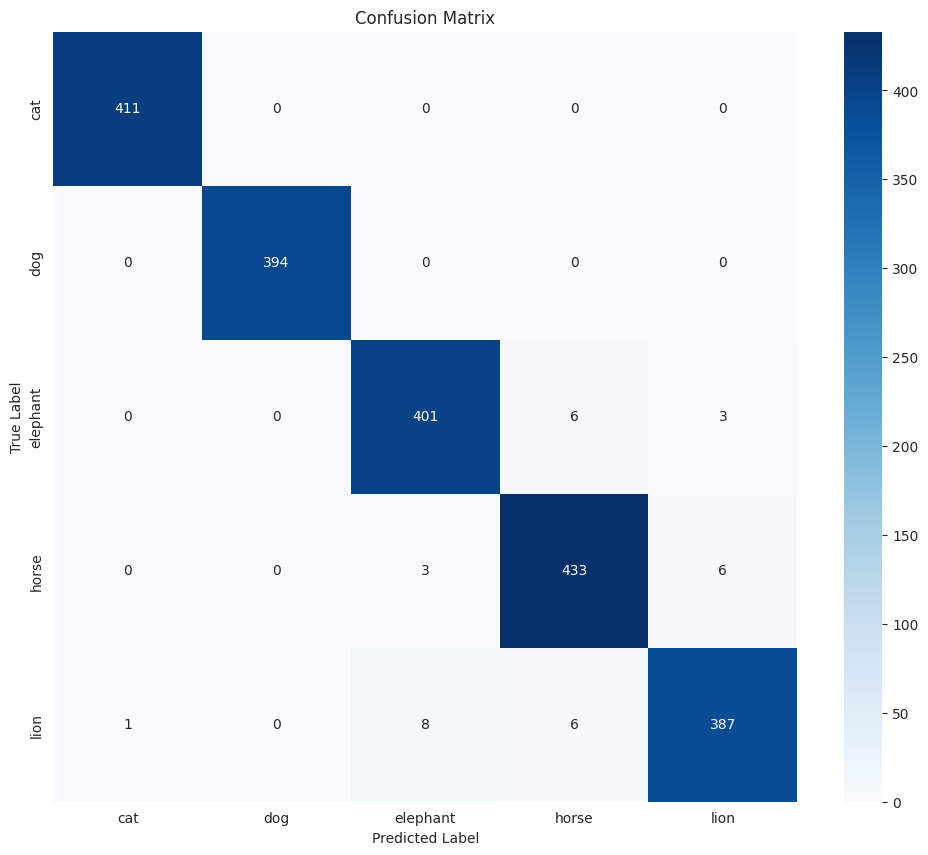

In [39]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

Menyimpan model dalam format TensorFlow SavedModel

In [41]:
model.export('/content/submission/saved_model')

Saved artifact at '/content/submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_2921')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  138641545221264: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  138641545222608: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  138636059833552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138636059833936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138636059834896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138636059834128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138636059832208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138636059835856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138636059836048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138636059835472: TensorSpec(shape=(), dtype=tf

Mengubah model Keras menjadi format TensorFlow Lite (.tflite), lalu menyimpannya bersama daftar label kelas.

In [43]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

os.makedirs("/content/submission/tflite", exist_ok=True)

# Simpan model .tflite
with open("/content/submission/tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

# Simpan label (jika pakai klasifikasi)
class_names = list(train_generator.class_indices.keys())
with open("/content/submission/tflite/label.txt", "w") as f:
    f.write("\n".join(class_names))

Saved artifact at '/tmp/tmpf_prfdin'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_2921')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  138641545221264: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  138641545222608: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  138636059833552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138636059833936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138636059834896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138636059834128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138636059832208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138636059835856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138636059836048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138636059835472: TensorSpec(shape=(), dtype=tf.resource, name

Mengonversi model ke format TensorFlow.js.

In [45]:
!pip install tensorflowjs
!tensorflowjs_converter --input_format=tf_saved_model /content/submission/saved_model /content/submission/tfjs_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB ? eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 61.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: ml_dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing in

2025-04-08 07:24:41.966851: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744097082.249488   46088 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744097082.327022   46088 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744097082.910401   46088 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744097082.910444   46088 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744097082.910453   46088 computation_placer.cc:177] computation placer alr

Menyimpan daftar semua library serta versi yang dipakai

In [58]:
!pip freeze > /content/submission/requirements.txt

## **10. Model Inference (Testing)**

Mencoba memprediksi gambar kucing yang diambil dari folder cat dengan model saved_model yang hasilnya sangat akurat, dari hal ini bisa disimpulkan bahwa model belajar dengan baik. Karena ada langkah inference, seharusnya memenuhi saran nomor 6, yaitu:

* **Melakukan inference menggunakan salah satu model (TF-Lite, TFJS atau savedmodel).**

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


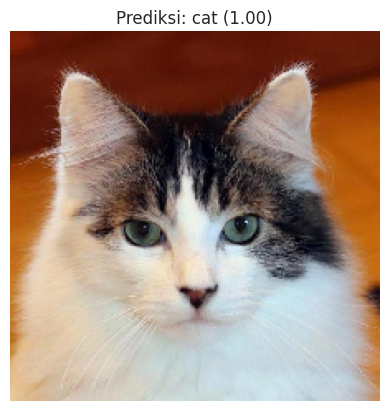

cat       : 1.00
dog       : 0.00
elephant  : 0.00
horse     : 0.00
lion      : 0.00


In [53]:
# Load model dari SavedModel
layer = TFSMLayer("/content/submission/saved_model", call_endpoint="serving_default")
model = Sequential([layer])

# Load dan pre-processing gambar
img_path = "/content/sample_data/submission/test/cat/cat1.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Prediksi
pred_dict = model.predict(img_array)
pred = list(pred_dict.values())[0][0]  # ambil array prediksi

# Label kelas
class_names = ["cat", "dog", "elephant", "horse", "lion"]

# Tampilkan gambar + hasil prediksi
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediksi: {class_names[np.argmax(pred)]} ({pred[np.argmax(pred)]:.2f})")
plt.show()

# Tampilkan semua skor prediksi
for i, prob in enumerate(pred):
    print(f"{class_names[i]:<10}: {prob:.2f}")


Selain dengan model saved_model, model yang disimpan dalam format tflite juga diuji untuk melihat akurasinya.

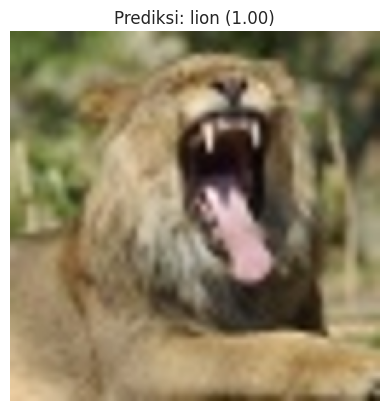

cat       : 0.00
dog       : 0.00
elephant  : 0.00
horse     : 0.00
lion      : 1.00


In [57]:
interpreter = tf.lite.Interpreter(model_path="/content/submission/tflite/model.tflite")
interpreter.allocate_tensors()

# Info input/output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Path ke gambar
img_path = "/content/sample_data/submission/test/lion/lion1049.jpg"

# Preprocessing gambar
img = Image.open(img_path).resize((224, 224))
img_array = np.array(img).astype(np.float32) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Inference
interpreter.set_tensor(input_details[0]['index'], img_array)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])[0]  # ambil hasil prediksi

# Label kelas
class_names = ["cat", "dog", "elephant", "horse", "lion"]

# Tampilkan gambar + prediksi
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediksi: {class_names[np.argmax(output_data)]} ({output_data[np.argmax(output_data)]:.2f})")
plt.show()

# Tampilkan probabilitas semua kelas
for i, prob in enumerate(output_data):
    print(f"{class_names[i]:<10}: {prob:.2f}")

Zip folder submission yang isinya hasil dari projek yang dibuat kali ini, kemudian download supaya tidak terhapus saat halaman google colabnya tereload.

In [ ]:
# ZIP folder submission
!zip -r /content/submission.zip /content/submission

# Download zip-nya
from google.colab import files
files.download("/content/submission.zip")

  adding: content/submission/ (stored 0%)
  adding: content/submission/tflite/ (stored 0%)
  adding: content/submission/tflite/label.txt (stored 0%)
  adding: content/submission/tflite/model.tflite (deflated 7%)
  adding: content/submission/tfjs_model/ (stored 0%)
  adding: content/submission/tfjs_model/group1-shard2of15.bin (deflated 7%)
  adding: content/submission/tfjs_model/group1-shard13of15.bin (deflated 8%)
  adding: content/submission/tfjs_model/group1-shard11of15.bin (deflated 8%)
  adding: content/submission/tfjs_model/group1-shard9of15.bin (deflated 7%)
  adding: content/submission/tfjs_model/group1-shard4of15.bin (deflated 7%)
  adding: content/submission/tfjs_model/model.json (deflated 97%)
  adding: content/submission/tfjs_model/group1-shard6of15.bin (deflated 7%)
  adding: content/submission/tfjs_model/group1-shard5of15.bin (deflated 7%)
  adding: content/submission/tfjs_model/group1-shard8of15.bin (deflated 7%)
  adding: content/submission/tfjs_model/group1-shard14of15.